# Loan Default Prediction
## Geekbrains AI/BigData Loan Default Prediction Competition

https://www.kaggle.com/c/credit-default-prediction-ai-big-data/leaderboard

### Problem statement

**The Task**

Your task in this competition is to predict if a person will default on a loan in the test.csv dataset. 

**The Data**

course_project_train.csv - contains the features and Credit Default as a target   
course_project_test.csv - contains the features only

**Target Variable**

Credit Default is non-fulfillment  of loan obligations.

**Evaluation Metric**

F1-score (sklearn.metrics.f1_score)

**Requirements**

*The Target metric*
* F1 > 0.5 while Precision > 0.5 and Recall > 0.5
* The metric is evaluated by the quality of the forecast for the main class (1 - Credit Default)

*The Solution has to consist of*
1. Jupyter Notebook 
2. CSV-file withe the forecast of the Target 

**Loading up the libraries and scripts**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool, cv

import warnings
warnings.simplefilter('ignore')

In [2]:
def fill_col(col):
    '''Fill the gaps by the median value.'''
    train[col].fillna(train[col].median(), inplace=True)

In [3]:
def fill_col_test(col):
    '''Fill the gaps by the median value from Train.'''
    test[col].fillna(train[col].median(), inplace=True)

In [4]:
title_dict = {'fontsize': 20, 'fontweight': 'bold', 'family': 'Calibri'}
label_dict = {'fontsize': '14', 'family': 'Calibri'}

### The Data overview

**Description**

* **Home Ownership**
* **Annual Income**
* **Years in current job** 
* **Tax Liens** 
* **Number of Open Accounts** 
* **Years of Credit History** 
* **Maximum Open Credit** 
* **Number of Credit Problems** 
* **Months since last delinquent** 
* **Bankruptcies** 
* **Purpose** 
* **Term**
* **Current Loan Amount** 
* **Current Credit Balance**
* **Monthly Debt**
* **Credit Default** - non-fulfillment of credit obligations (0-repaid on time, 1-delay)

**The Path**

In [5]:
# input
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Loading the data

In [6]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [8]:
train.describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  7500.000000   5.943000e+03  7500.000000              7500.000000   
mean   3749.500000   1.366392e+06     0.030133                11.130933   
std    2165.207842   8.453392e+05     0.271604                 4.908924   
min       0.000000   1.645970e+05     0.000000                 2.000000   
25%    1874.750000   8.443410e+05     0.000000                 8.000000   
50%    3749.500000   1.168386e+06     0.000000                10.000000   
75%    5624.250000   1.640137e+06     0.000000                14.000000   
max    7499.000000   1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
Id                              2500 non-null int64
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    198

In [10]:
test.describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  2500.00000   1.987000e+03  2500.000000              2500.000000   
mean   8749.50000   1.366922e+06     0.035200                11.184400   
std     721.83216   9.171252e+05     0.386291                 4.852774   
min    7500.00000   1.065330e+05     0.000000                 1.000000   
25%    8124.75000   8.523115e+05     0.000000                 8.000000   
50%    8749.50000   1.178475e+06     0.000000                10.000000   
75%    9374.25000   1.629734e+06     0.000000                14.000000   
max    9999.00000   1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

### Missing data processing

In [11]:
len(train) - train.count()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [12]:
len(test) - test.count()

Id                                 0
Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Gaps in the quantitative features**

We will fill in the gaps in "Months since last delinquent" by 0.

In [13]:
train['Months since last delinquent'].fillna(0, inplace=True)
test['Months since last delinquent'].fillna(0, inplace=True)

The "Annual Income" and "Credit Score" columns have a very large amount of missing data. But these features are likely very important, gaps need to be filled.

In [14]:
train.loc[train['Annual Income'].isnull(), :].describe()

Id  Annual Income    Tax Liens  Number of Open Accounts  \
count  1557.000000            0.0  1557.000000              1557.000000   
mean   3690.201028            NaN     0.033398                11.151574   
std    2177.866805            NaN     0.280313                 4.935590   
min       5.000000            NaN     0.000000                 2.000000   
25%    1742.000000            NaN     0.000000                 8.000000   
50%    3747.000000            NaN     0.000000                10.000000   
75%    5583.000000            NaN     0.000000                14.000000   
max    7499.000000            NaN     4.000000                33.000000   

       Years of Credit History  Maximum Open Credit  \
count              1557.000000         1.557000e+03   
mean                 18.336737         1.489092e+06   
std                   7.038592         3.305621e+07   
min                   4.300000         0.000000e+00   
25%                  13.500000         2.832280e+05   
50%                  17.300000         4.862660e+05   
75%                  21.900000         7.942660e+05   
max                  51.900000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                1557.000000                   1557.000000   1555.000000   
mean                    0.171484                     15.170841      0.113826   
std                     0.500137                     22.400430      0.327673   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                      0.000000      0.000000   
50%                     0.000000                      0.000000      0.000000   
75%                     0.000000                     28.000000      0.000000   
max                     5.000000                     83.000000      2.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  \
count          1557.000000            1.557000e+03   1557.000000   
mean         300744.253051            2.860604e+05  18451.107900   
std          179179.260062            3.048984e+05  12084.036473   
min           21472.000000            0.000000e+00      0.000000   
25%          167684.000000            1.140760e+05  10071.000000   
50%          262856.000000            2.058650e+05  16048.000000   
75%          404096.000000            3.572190e+05  23883.000000   
max          788942.000000            3.944514e+06  96177.000000   

       Credit Score  Credit Default  
count           0.0     1557.000000  
mean            NaN        0.339756  
std             NaN        0.473778  
min             NaN        0.000000  
25%             NaN        0.000000  
50%             NaN        0.000000  
75%             NaN        1.000000  
max             NaN        1.000000

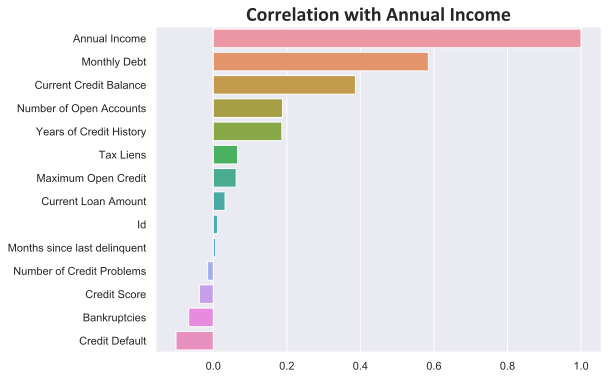

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(x=train.corr().iloc[:, 1].sort_values(ascending=False).values, 
            y=train.corr().iloc[:, 1].sort_values(ascending=False).index)
plt.title('Correlation with Annual Income', fontdict=title_dict);

The amount of "Monthly Debt" depends on the "Annual Income". Let's calculate the ratio of average income to average debt and calculate the approximate annual income in the lines with gaps.

In [16]:
notnull_income = train.loc[train['Annual Income'].notnull(), :]
dev = notnull_income['Annual Income'].mean() / notnull_income['Monthly Debt'].mean()
train['Annual Income'].fillna(train['Monthly Debt'] * dev, inplace=True)
test['Annual Income'].fillna(test['Monthly Debt'] * dev, inplace=True)

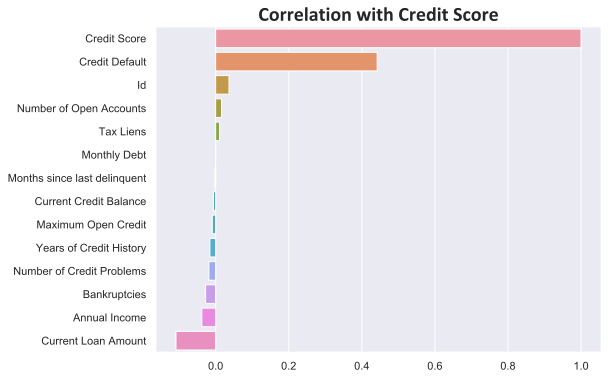

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(x=train.corr().iloc[:, -2].sort_values(ascending=False).values, 
            y=train.corr().iloc[:, -2].sort_values(ascending=False).index)
plt.title('Correlation with Credit Score', fontdict=title_dict);

"Credit Score" is strongly correlated with the target variable. And there is a weak inverse relationship to "Current Loan Amount".

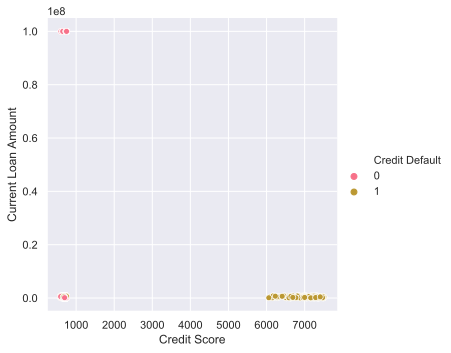

In [18]:
sns.relplot(x="Credit Score", y="Current Loan Amount", hue='Credit Default', data=train);

In [19]:
train['Credit Score'].fillna(3000, inplace=True)

In [20]:
test['Credit Score'].fillna(3000, inplace=True)

In [21]:
fill_col('Bankruptcies')
fill_col_test('Bankruptcies')

**Gaps in the nominative features**

In [22]:
def fill_nom_col(col):   
    '''Fill the gaps with the mode'''
    train[col].fillna(train[col].mode().iloc[0], inplace=True)

In [23]:
def fill_nom_col_test(col):  
    '''Fill the gaps with the mode estimated on Train'''
    test[col].fillna(train[col].mode().iloc[0], inplace=True)

In [24]:
fill_nom_col('Years in current job')
fill_nom_col_test('Years in current job')

### The Data overview

Text(0.5, 1.0, 'Correlation matrix')

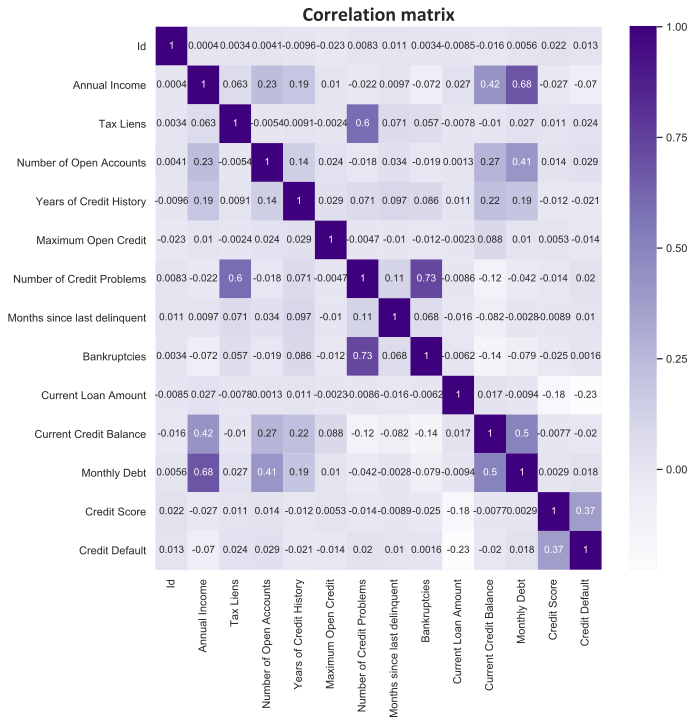

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.title('Correlation matrix', fontdict=title_dict)

**Overview of the target variable**

In [26]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [27]:
target = 'Credit Default'

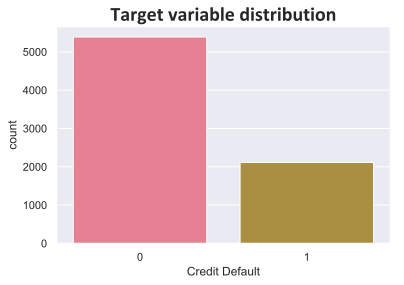

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=train)
plt.title('Target variable distribution', fontdict=title_dict);

The sample is not balanced by the target variable.

**Review of quantitative characteristics, reduction of types and replacement of emissions by median values**

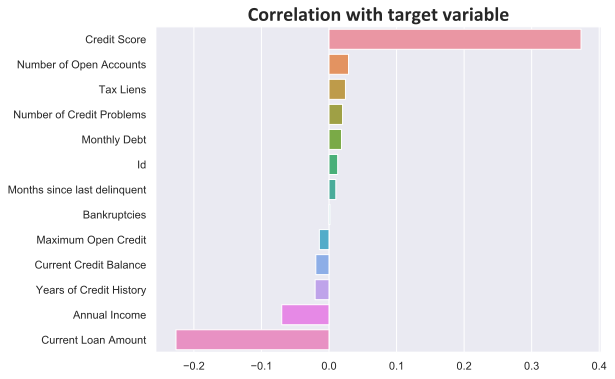

In [29]:
corr_with_target = train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable', fontdict=title_dict);

In [30]:
def feat_plot(col):        
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    default = train.loc[train ['Credit Default'] == 1, col]
    not_default = train.loc[train ['Credit Default'] == 0, col]
    ax1.hist((default, not_default), 
             bins=20, 
             histtype='stepfilled', 
             alpha=0.3, 
             color=('red', 'green'), 
             density=True, 
             label=('Credit Default 1', 'Credit Default 0'))
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_title(col)
     
    ax2.boxplot(train[col])
    ax2.set_title(col)
    
   # Let's compare with the testing dataset.
    ax3.hist(test[col], bins=20)
    ax3.set_title('Test')
    
    ax4.boxplot(test[col])
    ax4.set_title('Test')
    
    fig.set_size_inches(10, 8)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)    

In [31]:
def change_col(col):
    '''Replaces outliers with median values'''
    train.loc[train[col] > train[col].quantile(.99), col] = train[col].median()
    train.loc[train[col] < train[col].quantile(.01), col] = train[col].median()

In [32]:
def change_col_test(col):
    '''Replaces outliers with median values from Train'''
    test.loc[test[col] > test[col].quantile(.99), col] = train[col].median()
    test.loc[test[col] < test[col].quantile(.01), col] = train[col].median()

**Annual Income**

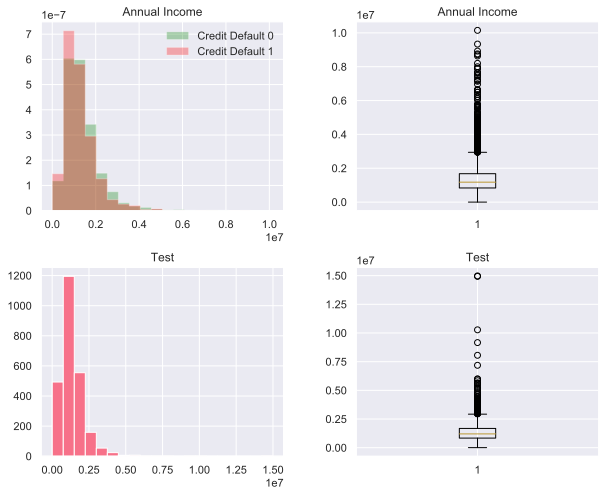

In [33]:
feat_plot('Annual Income')

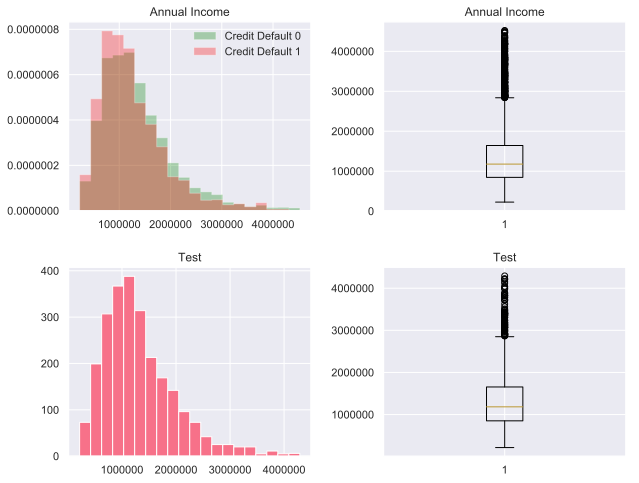

In [34]:
change_col('Annual Income')
change_col_test('Annual Income')
feat_plot('Annual Income')

**Tax Liens**

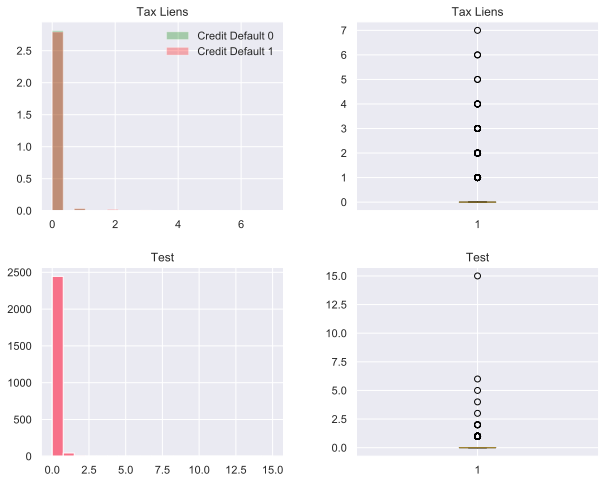

In [35]:
feat_plot('Tax Liens')

"Tax Liens" are obviously a categorical feature.

In [36]:
train['Tax Liens'].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

In [37]:
train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Let's bring the feature "Tax Liens" to binomial type. Those who have tax liens will receive class 1, those who do not-0.

In [38]:
train.loc[train['Tax Liens'] > 0, 'Tax Liens'] = 1
train['Tax Liens'] = train['Tax Liens'].astype('int')

Immediately make changes to the test.

In [39]:
test.loc[test['Tax Liens'] > 0, 'Tax Liens'] = 1
test['Tax Liens'] = test['Tax Liens'].astype('int')

**Number of Open Accounts**

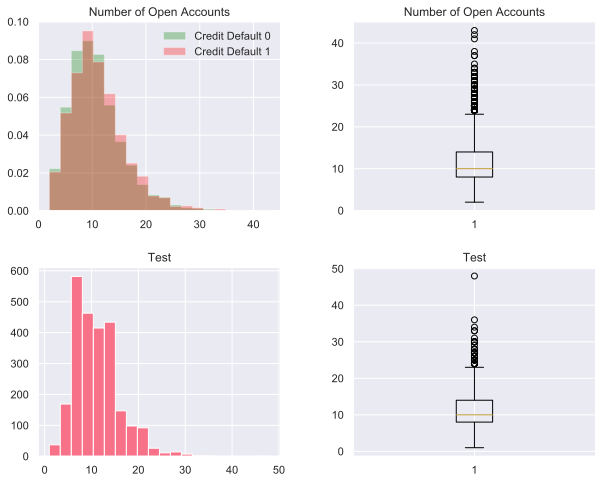

In [40]:
feat_plot('Number of Open Accounts')

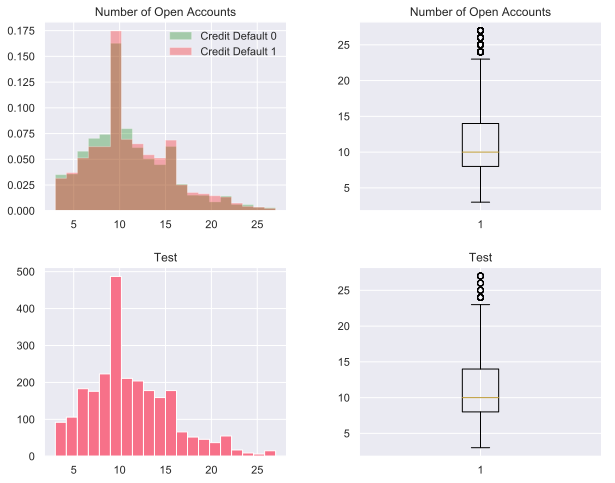

In [41]:
change_col('Number of Open Accounts')
change_col_test('Number of Open Accounts')
feat_plot('Number of Open Accounts')

**Years of Credit History**

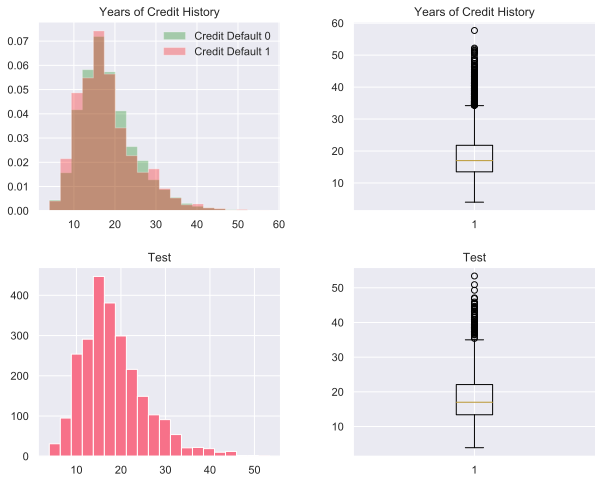

In [42]:
feat_plot('Years of Credit History')

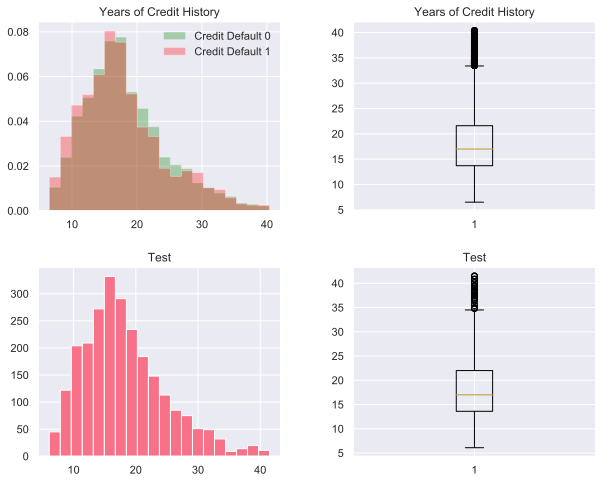

In [43]:
change_col('Years of Credit History')
change_col_test('Years of Credit History')
feat_plot('Years of Credit History')

**Maximum Open Credit**

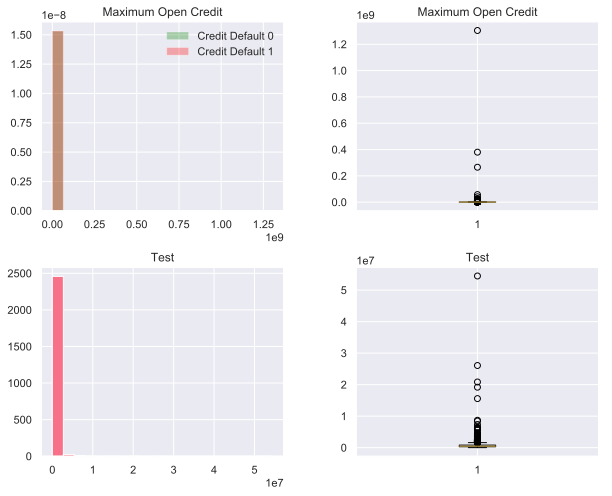

In [44]:
feat_plot('Maximum Open Credit')

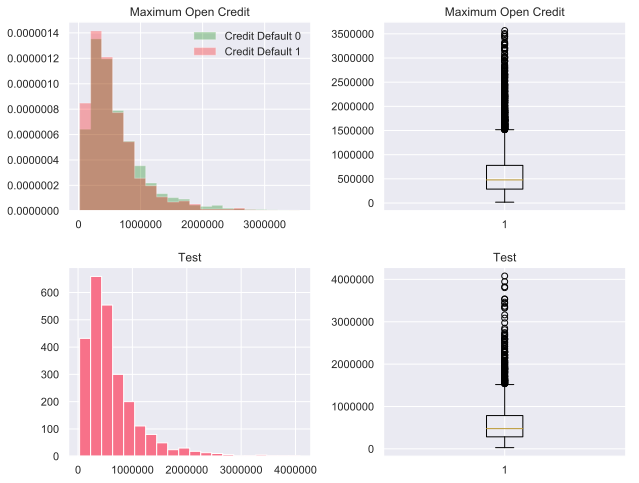

In [45]:
change_col('Maximum Open Credit')
change_col_test('Maximum Open Credit')
feat_plot('Maximum Open Credit')

**Number of Credit Problems**

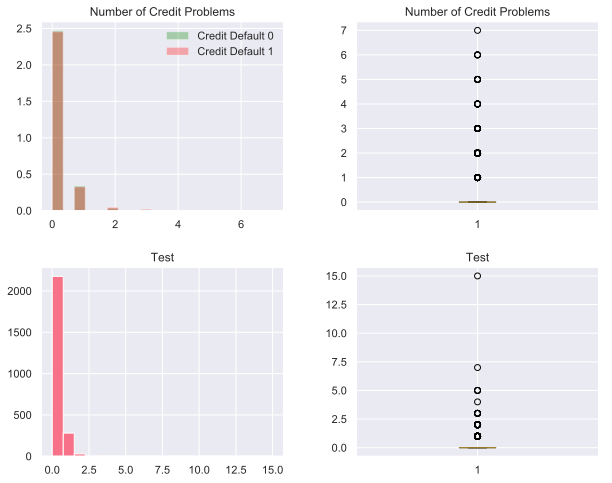

In [46]:
feat_plot('Number of Credit Problems')

"Number of Credit Problems" is a categorical feature.

In [47]:
train['Number of Credit Problems'].unique()

array([1., 0., 3., 2., 6., 4., 5., 7.])

Assign lable 0 to those who had no problems with credit, and 1-to those who had.

In [48]:
train.loc[train['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
train['Number of Credit Problems'] = train['Number of Credit Problems'].astype('int')

Let's repeat the operation for the test.

In [49]:
test.loc[test['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test['Number of Credit Problems'] = test['Number of Credit Problems'].astype('int')

**Months since last delinquent**

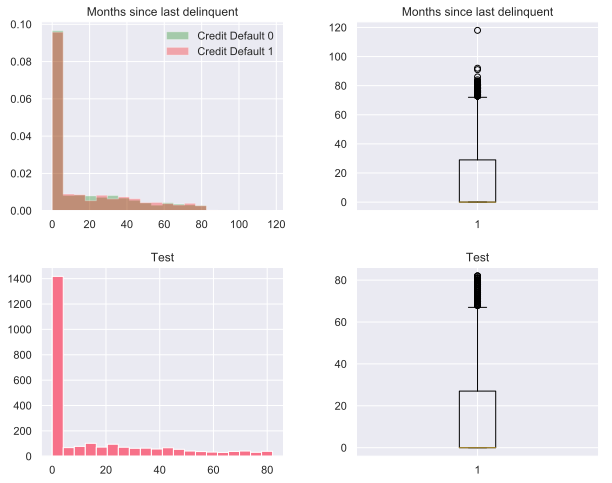

In [50]:
feat_plot('Months since last delinquent')

This makes sense to bring the feature "Months since last delinquent" to binomial type. 1 - the delay happened, 0 - it did not.

In [51]:
train.loc[train['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
train['Months since last delinquent'] = train['Months since last delinquent'].astype('int')

In [52]:
test.loc[test['Months since last delinquent'] > 0, 'Months since last delinquent'] = 1
test['Months since last delinquent'] = test['Months since last delinquent'].astype('int')

**Bankruptcies**

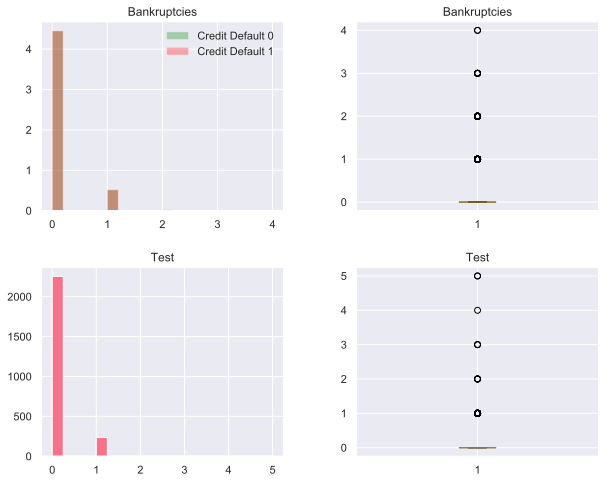

In [53]:
feat_plot('Bankruptcies')

A categorical feature again.

In [54]:
train['Bankruptcies'].unique()

array([1., 0., 3., 2., 4.])

We will assign the class 0 to those who did not have bankruptcies, and 1 to all others.

In [55]:
train.loc[train['Bankruptcies'] > 0, 'Bankruptcies'] = 1
train['Bankruptcies'] = train['Bankruptcies'].astype('int')

In [56]:
test.loc[test['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test['Bankruptcies'] = test['Bankruptcies'].astype('int')

**Current Loan Amount**

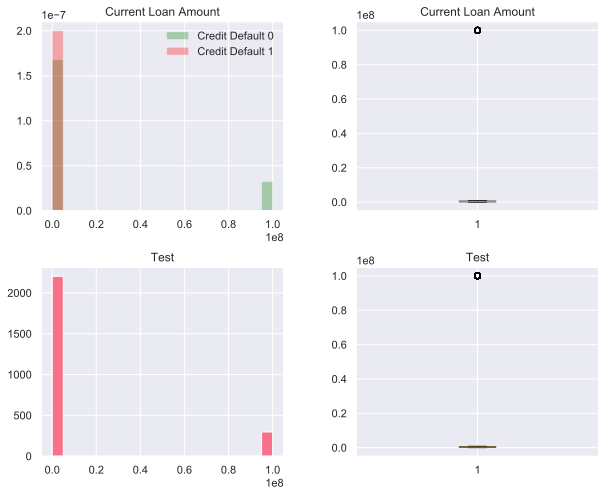

In [57]:
feat_plot('Current Loan Amount')

In [58]:
train.loc[train['Current Loan Amount'] == 99999999.0].describe()

Id  Annual Income   Tax Liens  Number of Open Accounts  \
count   870.000000   8.700000e+02  870.000000               870.000000   
mean   3698.718391   1.360767e+06    0.014943                10.967816   
std    2147.679755   6.932119e+05    0.121393                 4.416610   
min       0.000000   2.444160e+05    0.000000                 3.000000   
25%    1917.500000   8.680198e+05    0.000000                 8.000000   
50%    3689.000000   1.223514e+06    0.000000                10.000000   
75%    5547.250000   1.693232e+06    0.000000                14.000000   
max    7497.000000   4.338859e+06    1.000000                26.000000   

       Years of Credit History  Maximum Open Credit  \
count               870.000000         8.700000e+02   
mean                 18.501954         6.536386e+05   
std                   6.539730         5.123032e+05   
min                   6.500000         2.675200e+04   
25%                  13.900000         3.058880e+05   
50%                  17.050000         5.056040e+05   
75%                  22.000000         8.319850e+05   
max                  40.300000         3.409934e+06   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                 870.000000                    870.000000    870.000000   
mean                    0.134483                      0.422989      0.105747   
std                     0.341367                      0.494318      0.307691   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                      0.000000      0.000000   
50%                     0.000000                      0.000000      0.000000   
75%                     0.000000                      1.000000      0.000000   
max                     1.000000                      1.000000      1.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  \
count                870.0            8.700000e+02    870.000000   
mean            99999999.0            3.028599e+05  17933.028736   
std                    0.0            3.590877e+05  12264.380264   
min             99999999.0            0.000000e+00      0.000000   
25%             99999999.0            1.145225e+05   9484.750000   
50%             99999999.0            2.134650e+05  15445.500000   
75%             99999999.0            3.633702e+05  23421.250000   
max             99999999.0            4.249673e+06  94674.000000   

       Credit Score  Credit Default  
count    870.000000           870.0  
mean     730.225287             0.0  
std       21.395230             0.0  
min      601.000000             0.0  
25%      726.000000             0.0  
50%      737.000000             0.0  
75%      744.000000             0.0  
max      751.000000             0.0

We see that the target variable in these lines is zero and the "Credit score" value is close to the average, 730. Let's allocate these lines in a separate class.

In [59]:
train['Loan Amount Cat'] = 1
train.loc[train['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

In [60]:
test['Loan Amount Cat'] = 1
test.loc[test['Current Loan Amount'] == 99999999.0, 'Loan Amount Cat'] = 0

**Current Credit Balance**

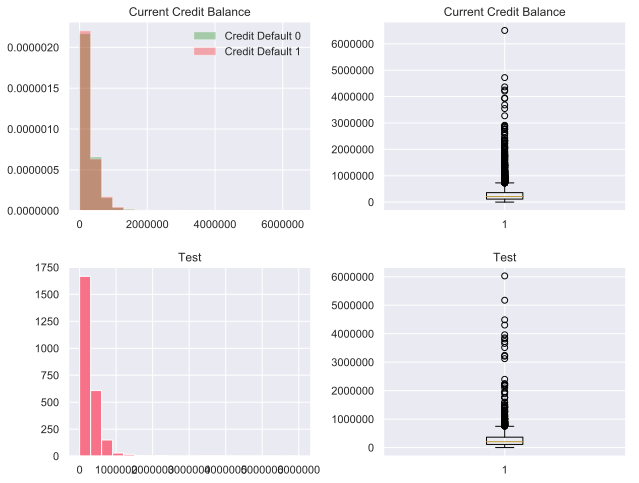

In [61]:
feat_plot('Current Credit Balance')

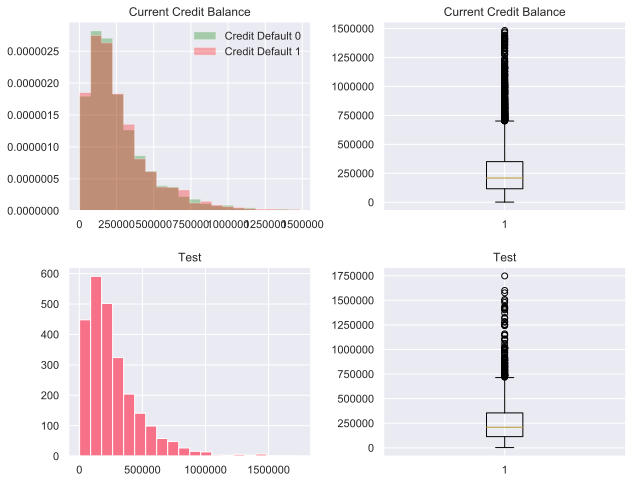

In [62]:
change_col('Current Credit Balance')
change_col_test('Current Credit Balance')
feat_plot('Current Credit Balance')

**Monthly Debt**

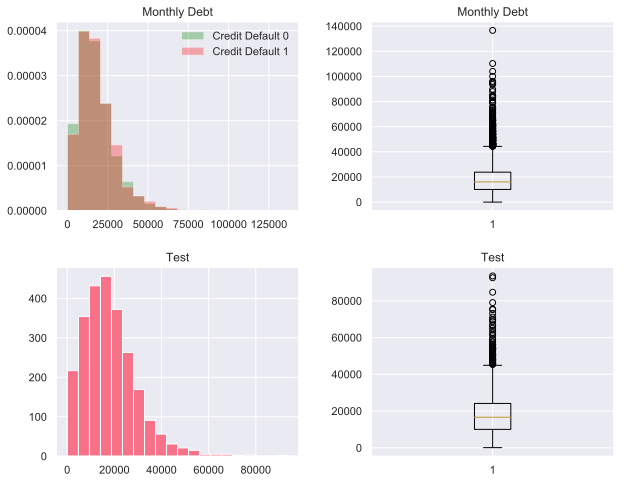

In [63]:
feat_plot('Monthly Debt')

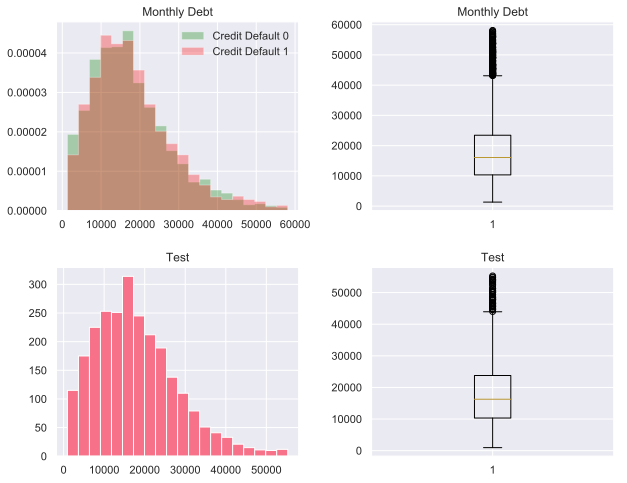

In [64]:
change_col('Monthly Debt')
change_col_test('Monthly Debt')
feat_plot('Monthly Debt')

**Credit Score**

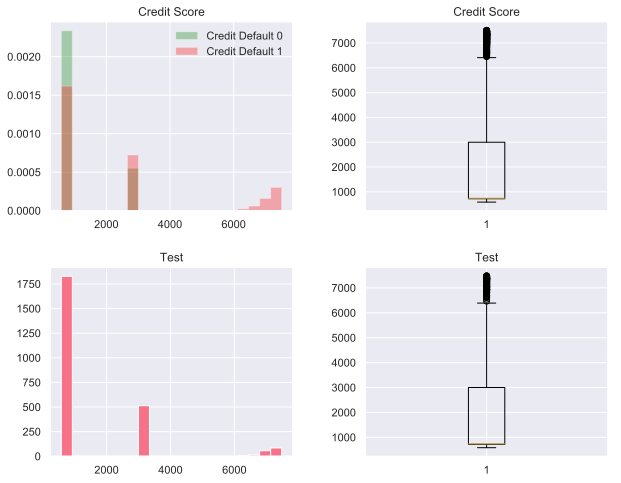

In [65]:
feat_plot('Credit Score')

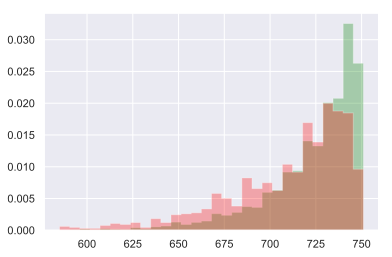

In [66]:
default = train.loc[
        (train ['Credit Default'] == 1) & (train['Credit Score'] < 800), 'Credit Score'
]
not_default = train.loc[
        (train ['Credit Default'] == 0) & (train['Credit Score'] < 800), 'Credit Score'
]
plt.hist((default, not_default), 
         bins=30, 
         histtype='stepfilled', 
         alpha=0.3, 
         color=('red', 'green'), 
         density=True, 
         label=('Credit Default 1', 'Credit Default 0')
);

In [67]:
train['Credit Score Cat'] = 0
train.loc[(train['Credit Score'] > 800), 'Credit Score Cat'] = 1
train.loc[(train['Credit Score'] == 3000), 'Credit Score Cat'] = 2
train.loc[(train['Credit Score'] < 735), 'Credit Score Cat'] = 2
train['Credit Score Cat'].astype('str')

0       0
1       0
2       0
3       2
4       2
       ..
7495    2
7496    1
7497    0
7498    2
7499    2
Name: Credit Score Cat, Length: 7500, dtype: object

In [68]:
test['Credit Score Cat'] = 0
test.loc[(test['Credit Score'] > 800), 'Credit Score Cat'] = 1
test.loc[(test['Credit Score'] == 3000), 'Credit Score Cat'] = 2
test.loc[(test['Credit Score'] < 735), 'Credit Score Cat'] = 2
test['Credit Score Cat'].astype('str')

0       2
1       2
2       1
3       0
4       2
       ..
2495    0
2496    2
2497    2
2498    0
2499    1
Name: Credit Score Cat, Length: 2500, dtype: object

**Overview of categorical features**

In [69]:
for cat_colname in train.select_dtypes(include='object').columns:
    print(str(cat_colname) + 
          '\n\n' + 
          str(train[cat_colname].value_counts()) + 
          '\n' + 
          '*' * 79 + 
          '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
*******************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
*******************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy       

In [70]:
def countplot(feature):
    '''Feature values grouped by the target variable.'''
    plt.figure(figsize=(10, 6))
    sns.countplot(y=feature, hue=target, data=train)
    plt.legend(title='Target', loc='lower right')

**Home Ownership**

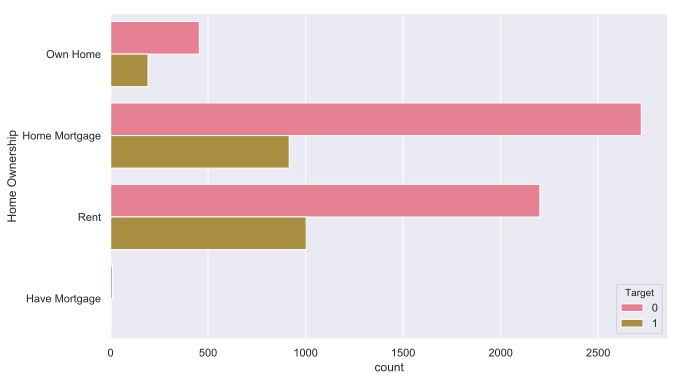

In [71]:
countplot("Home Ownership")

**Years in current job**

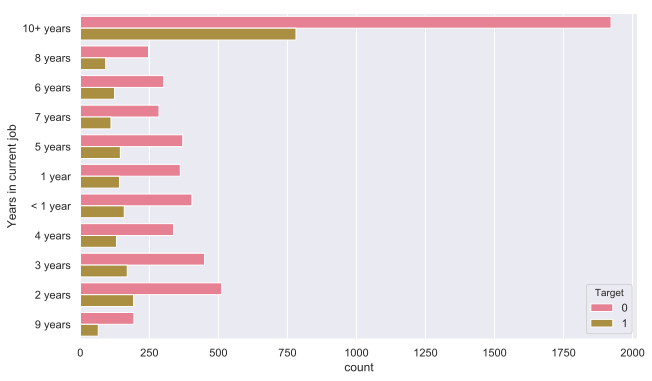

In [72]:
countplot("Years in current job")

In [73]:
train.loc[train['Years in current job'] == '< 1 year', 
          'Years in current job'] = 'lesser 1 year'
test.loc[test['Years in current job'] == '< 1 year', 
         'Years in current job'] = 'lesser 1 year'

**Purpose**

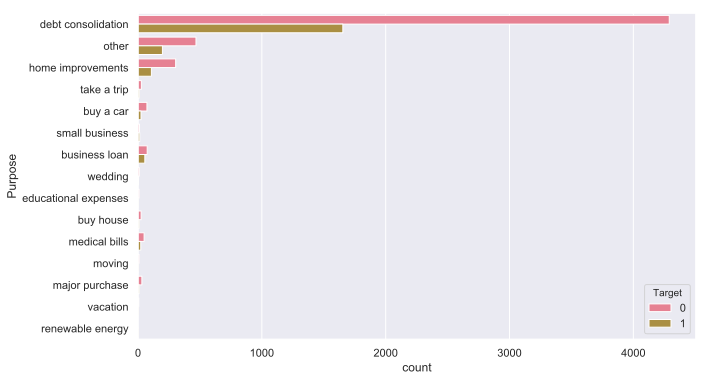

In [74]:
countplot("Purpose")

Let's reduce the number of categories. Let's join the categories "business loan" and "small business", they have a large share of loan default. Let's also join small categories.

In [75]:
train.loc[train['Purpose'] == 'small business', 'Purpose'] = 'business loan'
train.loc[train['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train.loc[train['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

In [76]:
train['Purpose'].value_counts()

debt consolidation    5944
other                  665
home improvements      412
major purchase         324
business loan          155
Name: Purpose, dtype: int64

In [77]:
test.loc[test['Purpose'] == 'small business', 'Purpose'] = 'business loan'
test.loc[test['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
test.loc[test['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'

**Term**

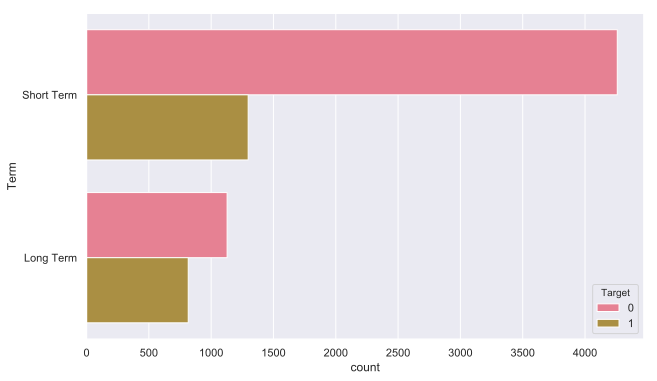

In [78]:
countplot("Term")

Let's transform this feature, let the Short Term be 0, and the Long Term-1.

In [79]:
train.loc[train['Term'] == 'Long Term', 'Term'] = 1
train.loc[train['Term'] == 'Short Term', 'Term'] = 0
train['Term'] = train['Term'].astype('int')

In [80]:
test.loc[test['Term'] == 'Long Term', 'Term'] = 1
test.loc[test['Term'] == 'Short Term', 'Term'] = 0
test['Term'] = test['Term'].astype('int')

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null object
Tax Liens                       7500 non-null int32
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null int32
Months since last delinquent    7500 non-null int32
Bankruptcies                    7500 non-null int32
Purpose                         7500 non-null object
Term                            7500 non-null int32
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-nul

### Feature selection

In [82]:
basic_features = train.columns.drop(target).drop('Id').tolist()
basic_features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat']

In [83]:
numeric_features = train.select_dtypes(
                    include='float').columns.tolist()
numeric_features

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [84]:
category_features = train.select_dtypes(
                    include=('object')).columns.tolist()
category_features

['Home Ownership', 'Years in current job', 'Purpose']

In [85]:
selected_features = basic_features
selected_features

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Credit Score Cat']

Since we don't need dummies for CatBoost, it's better to save the datasets and feature lists.

In [86]:
CAT_DATASET_PATH = 'for_cat.csv'
train.to_csv(CAT_DATASET_PATH, index=False, encoding='utf-8')

CAT_TEST_DATASET_PATH = 'for_cat_test.csv'
test.to_csv(CAT_TEST_DATASET_PATH, index=False, encoding='utf-8')

**Dummies**

In [87]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

#### New feature lists

In [88]:
basic_feats = train.columns.drop(target).drop('Id').tolist()

In [89]:
numeric_feats = train.select_dtypes(include='float').columns.tolist()

In [90]:
category_feats = train.select_dtypes(include=('uint8')).columns.tolist()

In [91]:
selected_feats = basic_feats

Let's look again at the correlation of features with the target variable.

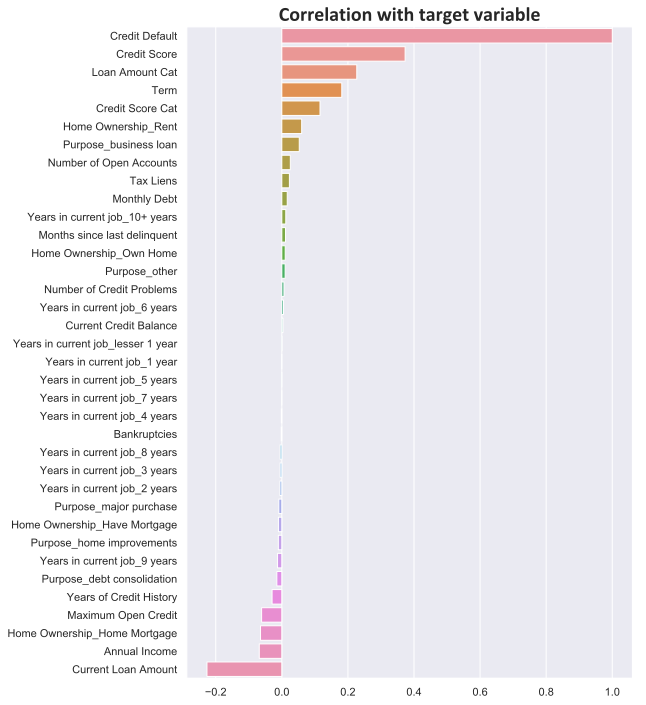

In [92]:
corr_with_target = train[selected_feats + 
                         [target]].corr().loc[target].sort_values(ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(x=corr_with_target.values, 
            y=corr_with_target.index)
plt.title('Correlation with target variable', 
          fontdict=title_dict);

### Data normalization, splitting into train and test, and balancing target variable classes

In [93]:
def norm_data(train, test, features, scaler):
    '''Normalize the data'''
    train_norm = train.copy()
    train_norm[features] = scaler.fit_transform(train_norm[features])
    test_norm = test.copy()
    test_norm[features] = scaler.transform(test_norm[features])
    return train_norm, test_norm

In [94]:
# MinMaxScaler
train_norm, test_norm = norm_data(
    train, test, 
    numeric_feats, 
    MinMaxScaler()
)

In [95]:
# StandardScaler
train_standard, test_standard = norm_data(
    train, test, 
    numeric_feats, 
    StandardScaler()
)

In [96]:
def balance_df_by_target(df, target_name):
    '''Return balanced on Target dataset'''
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [97]:
def split_and_balance_df(train_norm, selected_feats, test_size):
    '''Split train_norm to X_train, y_train and balance X_train'''
    X = train_norm[selected_feats]
    y = train_norm[target]
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, shuffle=True, test_size=test_size, random_state=42)
    df_for_balancing = pd.concat([X_train, y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, target)
    X_train = df_balanced.drop(columns=target)
    y_train = df_balanced[target]
    return X_train, X_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = split_and_balance_df(
        train_norm, selected_feats, test_size=0.25
)

In [99]:
X_train_s, X_test_s, y_train_s, y_test_s = split_and_balance_df(
        train_standard, selected_feats, test_size=0.25
)

### Basic models building and evaluation

In [100]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    '''Print the report'''
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [101]:
def model(model, X_train, y_train, X_test, y_test, features):
    '''Return model'''
    model.fit(X_train[features], y_train) 
    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])
    print(get_classification_report(y_train, y_train_pred, y_test, y_test_pred))
    return model

## LogisticRegression

In [102]:
# LogisticRegression & MinMaxScaler
model_lr = model(
            LogisticRegression(), 
            X_train, y_train, X_test, y_test, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      4074
           1       0.66      0.57      0.61      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.68      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1313
           1       0.51      0.57      0.54       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1002  311
1                242  320
None


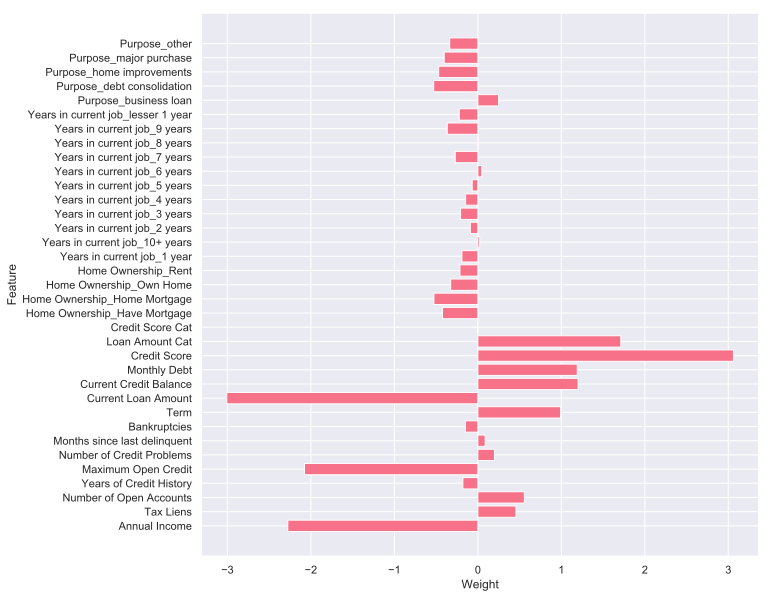

In [103]:
# The features and their weights
plt.rcParams['figure.figsize'] = 10, 10
plt.barh(selected_feats, model_lr.coef_.flatten())

plt.xlabel("Weight")
plt.ylabel("Feature")

plt.show()

In [104]:
# Drop the less weighted features
selected_feats = np.array(selected_feats)
coefs = dict(zip(selected_feats, model_lr.coef_.flatten()))
new_feats = []
for feat, coef in coefs.items():
    if abs(coef) > 0.25:
        new_feats.append(feat)
new_feats

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Loan Amount Cat',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Years in current job_7 years',
 'Years in current job_9 years',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_other']

In [105]:
# LogisticRegression & MinMaxScaler & most important features
model_lr_new_feats = model(
                    LogisticRegression(), 
                    X_train, y_train, X_test, y_test, 
                    features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4074
           1       0.65      0.57      0.61      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1313
           1       0.51      0.59      0.55       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.67      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               999  314
1               233  329
None


In [106]:
# LogisticRegression & StandardScaler
model_lr_s = model(
            LogisticRegression(), 
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=selected_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      4074
           1       0.66      0.57      0.61      3102

   micro avg       0.69      0.69      0.69      7176
   macro avg       0.68      0.67      0.68      7176
weighted avg       0.68      0.69      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1313
           1       0.51      0.57      0.54       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.66      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1003  310
1                241  321
None


In [107]:
# LogisticRegression & StandardScaler & most important features
model_lr_s = model(
            LogisticRegression(),
            X_train_s, y_train_s, X_test_s, y_test_s, 
            features=new_feats
)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      4074
           1       0.65      0.57      0.61      3102

   micro avg       0.68      0.68      0.68      7176
   macro avg       0.68      0.67      0.67      7176
weighted avg       0.68      0.68      0.68      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1313
           1       0.51      0.59      0.55       562

   micro avg       0.71      0.71      0.71      1875
   macro avg       0.66      0.67      0.67      1875
weighted avg       0.72      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               997  316
1               232  330
None


In [108]:
# test_standard['Credit Default'] = model_lr_s.predict(
#     test_standard[new_feats])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_standard.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

The result of the model on kaggle.com

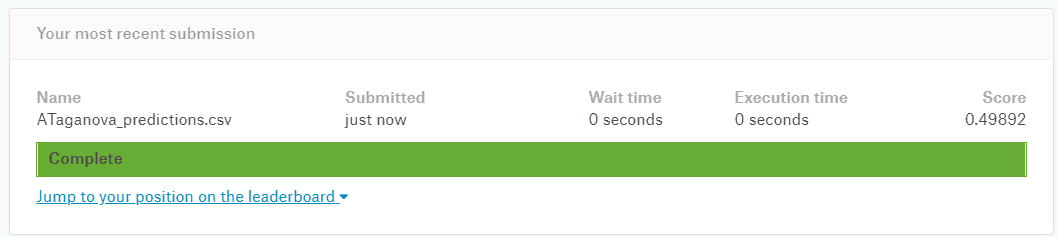

## XGBoost

In [109]:
# XGBoost & MinMaxScaler
model_xgb = model(xgb.XGBClassifier(random_state=42),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4074
           1       0.79      0.57      0.66      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.76      0.73      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1313
           1       0.56      0.49      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1098  215
1                288  274
None


In [110]:
# XGBoost & StandardScaler
model_xgb_s = model(xgb.XGBClassifier(random_state=42), 
                    X_train_s, y_train_s, X_test_s, y_test_s, 
                    features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4074
           1       0.79      0.57      0.66      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.76      0.73      0.73      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1313
           1       0.56      0.49      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1098  215
1                288  274
None


In [111]:
# test_norm['Credit Default'] = model_xgb.predict(test_norm[selected_feats])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

## LightGBM

In [112]:
# LightGBM & MinMaxScaler
model_lgbm = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train, y_train, X_test, y_test, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4074
           1       0.78      0.61      0.69      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.76      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.50      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1090  223
1                281  281
None


In [113]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    '''Return the list of the most important features'''
    feature_importances = pd.DataFrame(
            {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
            'importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

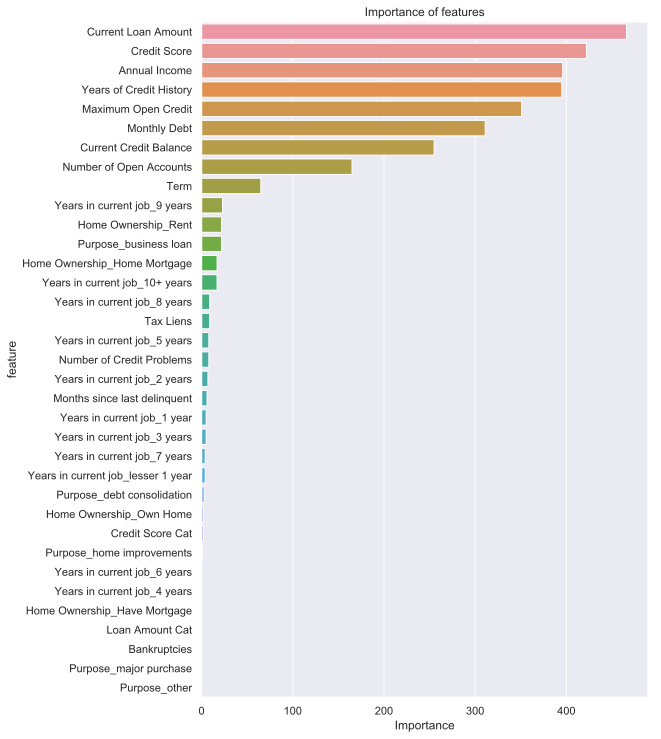

In [114]:
important_features_top = show_feature_importances(
        X_train.columns, 
        model_lgbm.feature_importances_, 
        get_top=15
)

In [115]:
# LightGBM & MinMaxScaler & important_features_top
model_lgbm_important_features_top = model(
                lgbm.LGBMClassifier(random_state=42, reg_alpha=7.0, reg_lambda=300.0),
                X_train, y_train, X_test, y_test, 
                features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      4074
           1       0.77      0.60      0.67      3102

   micro avg       0.75      0.75      0.75      7176
   macro avg       0.75      0.73      0.74      7176
weighted avg       0.75      0.75      0.74      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.51      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1086  227
1                278  284
None


In [116]:
# test_norm['Credit Default'] = model_lgbm_important_features_top.predict(test_norm[important_features_top])
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

The result of the model on kaggle.com

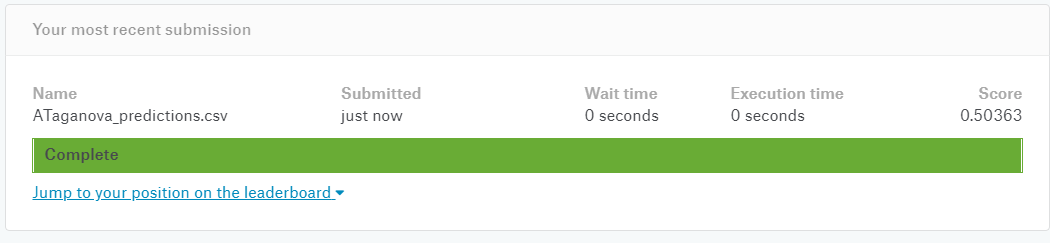

In [117]:
# LightGBM & StandardScaler
model_lgbm_s = model(lgbm.LGBMClassifier(random_state=42, reg_lambda=300),
                  X_train_s, y_train_s, X_test_s, y_test_s, 
                  features=selected_feats)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4074
           1       0.78      0.61      0.69      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.76      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.55      0.50      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.67      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1085  228
1                279  283
None


## CatBoost

In [118]:
train = pd.read_csv(CAT_DATASET_PATH)
test = pd.read_csv(CAT_TEST_DATASET_PATH)

In [119]:
train_norm_cat, test_norm_cat = norm_data(
    train, test, numeric_features, MinMaxScaler())

In [120]:
train_norm_cat_s, test_norm_cat_s = norm_data(
    train, test, numeric_features, StandardScaler())

In [121]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = split_and_balance_df(
    train_norm_cat, selected_features, test_size=0.25)

In [122]:
X_cat_train_s, X_cat_test_s, y_cat_train_s, y_cat_test_s = split_and_balance_df(
    train_norm_cat_s, selected_features, test_size=0.25)

In [123]:
# CatBoost & MinMaxScaler
model_catb = model(catb.CatBoostClassifier
                   (cat_features=category_features, 
                     l2_leaf_reg=300, 
                     random_state=42, 
                     silent=True), 
                   X_cat_train, y_cat_train, 
                   X_cat_test, y_cat_test, 
                   features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4074
           1       0.78      0.61      0.68      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.76      0.74      0.74      7176
weighted avg       0.76      0.76      0.75      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1313
           1       0.56      0.51      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1085  228
1                276  286
None


In [124]:
# CatBoost & StandardScaler
model_catb_s = model(catb.CatBoostClassifier
                     (cat_features=category_features, 
                       l2_leaf_reg=300, 
                       random_state=42, 
                       silent=True), 
                     X_cat_train_s, y_cat_train_s, 
                     X_cat_test_s, y_cat_test_s, 
                     features=selected_features)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      4074
           1       0.79      0.62      0.69      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.77      0.75      0.75      7176
weighted avg       0.77      0.76      0.76      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.54      0.51      0.53       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.67      0.66      0.67      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1075  238
1                277  285
None


Let's see what features were the most important, and see if the result will not improve, if we leave only these features.

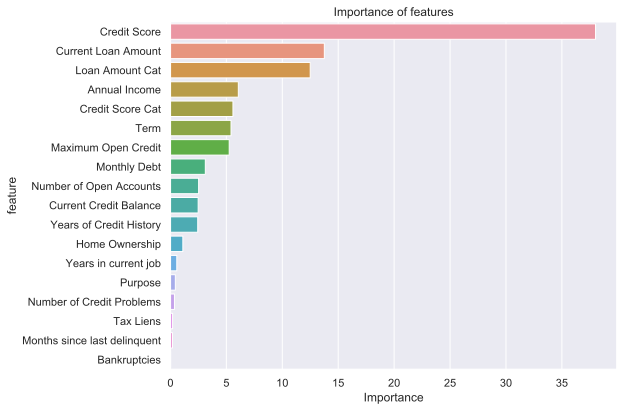

In [125]:
important_features_top = show_feature_importances(
                    X_cat_train_s.columns, 
                    model_catb.feature_importances_, 
                    get_top=15
)

In [126]:
# CatBoost & StandardScaler & important_features_top
model_catb_s_important_features_top = model(
                        catb.CatBoostClassifier
                        (cat_features=category_features, 
                          l2_leaf_reg=300, 
                          random_state=42, 
                          silent=True), 
                        X_cat_train_s, y_cat_train_s, 
                        X_cat_test_s, y_cat_test_s, 
                        features=important_features_top)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4074
           1       0.78      0.62      0.69      3102

   micro avg       0.76      0.76      0.76      7176
   macro avg       0.77      0.74      0.75      7176
weighted avg       0.76      0.76      0.76      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.55      0.52      0.54       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1076  237
1                270  292
None


In [127]:
# # Prediction on Test
# test_norm_cat_s['Credit Default'] = model_catb_s.predict(
#                         test_norm_cat_s[selected_features])
# test_norm_cat_s['Credit Default'] = test_norm_cat_s[
#                             'Credit Default'].astype('int')
# PRED_PATH = 'ATaganova_predictions.csv'
# test_norm_cat_s.loc[:, ['Id', 'Credit Default']].to_csv(
#     PRED_PATH, index=False, encoding='utf-8')

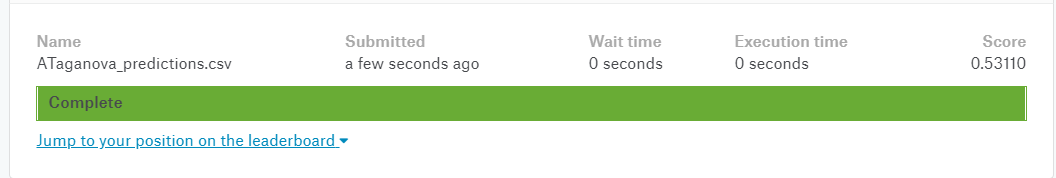

And that is the best score on kaggle.com so far.